In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pybamm
import pickle
import os
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

In [3]:
# Here I am not going to work with changing the initial conditions the gradient descent
# so this is taking the ICs for granted 
Ms = 32
n4 = 4
F = 9.649e4
S8_initial = 2.6730
ns8 = 8
S4_initial = 0.0128
ns4 = 4
cth = ((3 * n4 * F * S8_initial / (ns8 * Ms)) + (n4 * F * S4_initial / (ns4 * Ms))) / 3600

# define the initial values in grams of various species
S8_initial_g = 2.6730
S4_initial_g = 0.0128
S2_initial_g = 4.3321e-6
S1_initial_g = 1.6321e-6
Sp_initial_g = 2.7e-06

# the total active material mass
m_s = S8_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [76]:
def discharge_function(inputs):
    
    fitted_params_dict, temp = inputs
    
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.MarinescuEtAl2016_ks_temp()
    
    # non-fitted parameters
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Ambient Temperature [K]": temp,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.1,
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        }
    )
    # fitted parameters (which are initial species values and initial voltage)
    params.update(fitted_params_dict)
    
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying number of time steps %f" %10**j)
        print("parameters are {}".format(fitted_params_dict))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries

            data = {'time' : t, 
                    'capacity' : Ah, 
                    'voltage' : V, 
                    'S8' : S8, 
                    'S4' : S4, 
                    'S2' : S2, 
                    'S1' : S1, 
                    'Sp' : Sp
                   } 
            return data
            
            break
        except:
            pass

In [17]:
all_params = [
    {
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5]
    }                      
]
temp_c = 30
temp_k = temp_c + 272.15
inputs = all_params[-1], temp_k

base_discharge_sim_dict = discharge_function(inputs)

Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

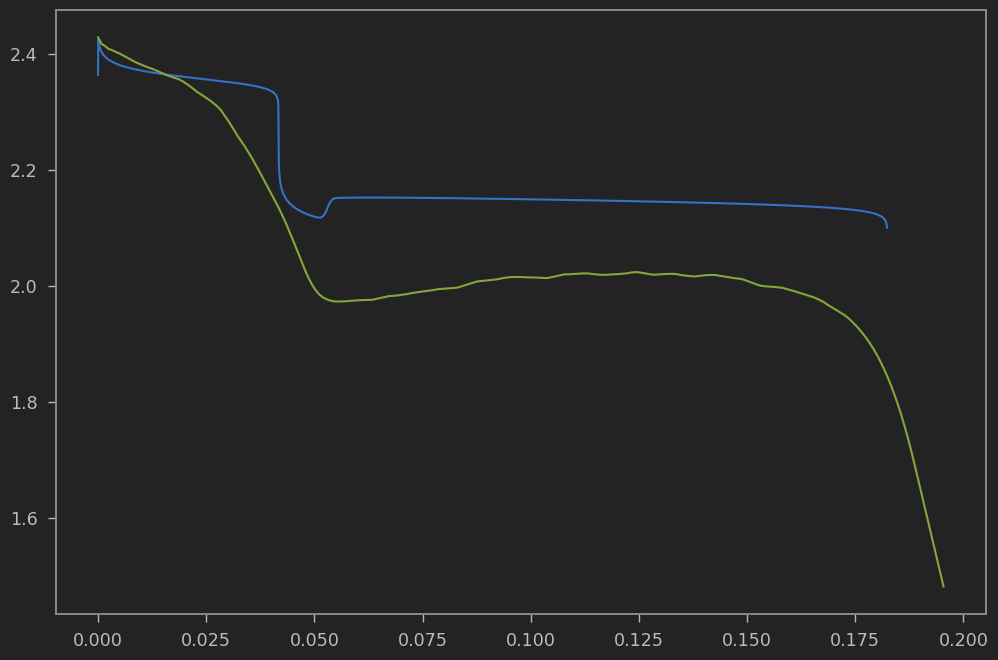

In [18]:
plt.plot(base_discharge_sim_dict['capacity'],base_discharge_sim_dict['voltage'] )
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
notify

In [66]:
# Here we will perform the charge fitting
def quick_norm(gradient):
    values = np.array(list(gradient.values()))
    return sum(values*values)

def gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage):
    fitted_params_dict, temp = inputs
    # create steps for each parameter to fit
    individually_stepped_params = []
    
    epsilon = 0.01
    for key in fitted_params_dict.keys():
        individually_stepped_params_dict = fitted_params_dict
        #print('Initial Dictionary')
        #print(individually_stepped_params_dict)
        individually_stepped_params_dict[key] = fitted_params_dict[key]*(1+epsilon)
        #print('Updated Dictionary')
        #print(individually_stepped_params_dict)
        individually_stepped_params.append(individually_stepped_params_dict)
    #print('\n\n\n')
    #print(individually_stepped_params)
    #print('\n\n\n')
    
    # run new simulations with individually stepped parameters
    individually_stepped_inputs = []
    for param_dict in individually_stepped_params:
        individually_stepped_inputs.append([param_dict, temp])
    
    #print('\n\n\n')
    #print('Performing Parallel Simulations')
    #print('\n\n\n')
    individually_stepped_sims = Parallel(n_jobs=-1)(delayed(discharge_function)(inputs) for inputs in individually_stepped_inputs)
    #print('\n\n\n')
    #print('Finished Performing Parallel Simulations')
    #print('\n\n\n')
    # downsample each sim to be able to subtract from base_sim for numerical derivative
    gradient = {}
    for i in range(0,len(individually_stepped_sims)):
        
        key = list(fitted_params_dict.keys())[i]
        sim = individually_stepped_sims[i]
        # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes

        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sim['capacity'], sim['voltage'])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon
        voltage_cost = sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage)
        #print(voltage_cost)
        mass_conservation_cost = (1e5)*2*(sim['S8'][0]+sim['S4'][0]+sim['S2'][0]+sim['S1'][0]+sim['Sp'][0] - .168)
        #print(mass_conservation_cost)
        #print(key != 'voltage')
        gamma = 1
        beta = 1e9
        shift = 1e-15
        if key != 'Initial Condition for Terminal Voltage [V]':
            if key[-7:] =='ion [g]':
                if key[-9] == 'S':
                    species = sim['S1'][0]
                    non_zero_cost = -gamma * (1 + (1-beta*(species-shift))*np.exp(beta*species) ) / (1+np.exp(beta*species))**2
                else:
                    species = sim[key[-10:-8]][0]
                    non_zero_cost = -gamma * (1 + (1-beta*(species-shift))*np.exp(beta*species) ) / (1+np.exp(beta*species))**2
            else:
                species = sim['Sp'][0]
                non_zero_cost = -gamma * (1 + (1-beta*(species-shift))*np.exp(beta*species) ) / (1+np.exp(beta*species))**2
            #print(non_zero_cost)
            gradient[key] = voltage_cost+mass_conservation_cost+non_zero_cost
        else:
            gradient[key] = voltage_cost
        #print(key)
        #print('Voltage Cost = ' + str(voltage_cost))
        #print('Mass Conservation Cost = ' + str(mass_conservation_cost))
        #print('Zero Species Value Cost = '+ str(non_zero_cost))
        #print('\n \n')
    #print('The gradient is:')
    #print(gradient)
    
    # perform parameter update
    lam = 1e-9
    #print('Gradient norm = ' + str(quick_norm(gradient)))
    updated_params_dict = {}
    for key in fitted_params_dict:
        updated_params_dict[key] = fitted_params_dict[key] - lam*(gradient[key] +  np.random.rand(1)[0])
    print('The updated parameters are:')
    for item in updated_params_dict:
        print(item)
        print(updated_params_dict[item])
    
    return updated_params_dict, gradient
    
    

def down_sampled_sim_voltage_func(Ah, V, exp_capacity, exp_voltage):

    # check if simulation stops short of experimental capacity and adjust
    if Ah[-1] < exp_capacity[-1]:
        temp_exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]
    else:
        temp_exp_capacity = exp_capacity
    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)
    
    return down_sampled_sim_voltage

def gradient_descent_proceedure(all_sims, all_params, temp):
    # get experimental data
    exp_capacity = discharge_data['30']['capacity']
    exp_voltage = discharge_data['30']['internal voltage'][0:len(exp_capacity)]
    
    # get new parameters
    params = all_params[-1]
    
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp = all_sims[-1].values()
    
    # get down-sampled sim voltage
    down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)
    
    condition = True
    while condition:
        inputs = all_params[-1], temp
        
        # perform gradient descent step from latest simulation & parameters
        print('\n\n Performing Gradient Descent Step \n\n')
        try:
            updated_params, gradient = gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage)

            # update parameter data
            all_params.append(updated_params)

            # perform simulation with new parameters
            inputs = all_params[-1], temp
            print('\n\n Performing New Simulation \n\n')
            new_base_sim = discharge_function(inputs)

            # down-sample sim data to experimental data
            t, Ah, V, S8, S4, S2, S1, Sp = new_base_sim.values()
            down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)

            # update simulation data set
            all_sims.append(new_base_sim)
        except:
            condition = False
        #if quick_norm(gradient)<1e-3:
        #    condition = False
        if len(all_sims) > 5:
            condition = False
            
    return all_sims, all_params

In [67]:
all_params = [
    {
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0]-0.15,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5]
    }                      
]
temp_c = 30
temp_k = temp_c + 272.15
all_sims = [base_discharge_sim_dict]
all_sims, all_params = gradient_descent_proceedure(all_sims, all_params, temp_k)



 Performing Gradient Descent Step 


The updated parameters are:
Initial Condition for Terminal Voltage [V]
2.2724999996924153
Initial Condition for S8 ion [g]
nan
Initial Condition for S4 ion [g]
nan
Initial Condition for S2 ion [g]
-6.284641121026303e-08
Initial Condition for S ion [g]
-2.3329121880273812e-07
Initial Condition for Precipitated Sulfur [g]
-1.6574364201109426e-07


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.2724999996924153, 'Initial Condition for S8 ion [g]': nan, 'Initial Condition for S4 ion [g]': nan, 'Initial Condition for S2 ion [g]': -6.284641121026303e-08, 'Initial Condition for S ion [g]': -2.3329121880273812e-07, 'Initial Condition for Precipitated Sulfur [g]': -1.6574364201109426e-07}
trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.2724999996924153, 'Initial Condition for S8 ion 

CasADi - 2021-02-12 13:45:44 WARNING("roots:jac_f_z failed: NaN detected for output jac_x_x0, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-02-12 13:45:44 WARNING("roots:jac_f_z failed: NaN detected for output jac_x_x0, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-02-12 13:45:44 WARNING("roots:jac_f_z failed: NaN detected for output jac_x_x0, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-02-12 13:45:44 WARNING("roots:jac_f_z failed: NaN detected for output jac_x_x0, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


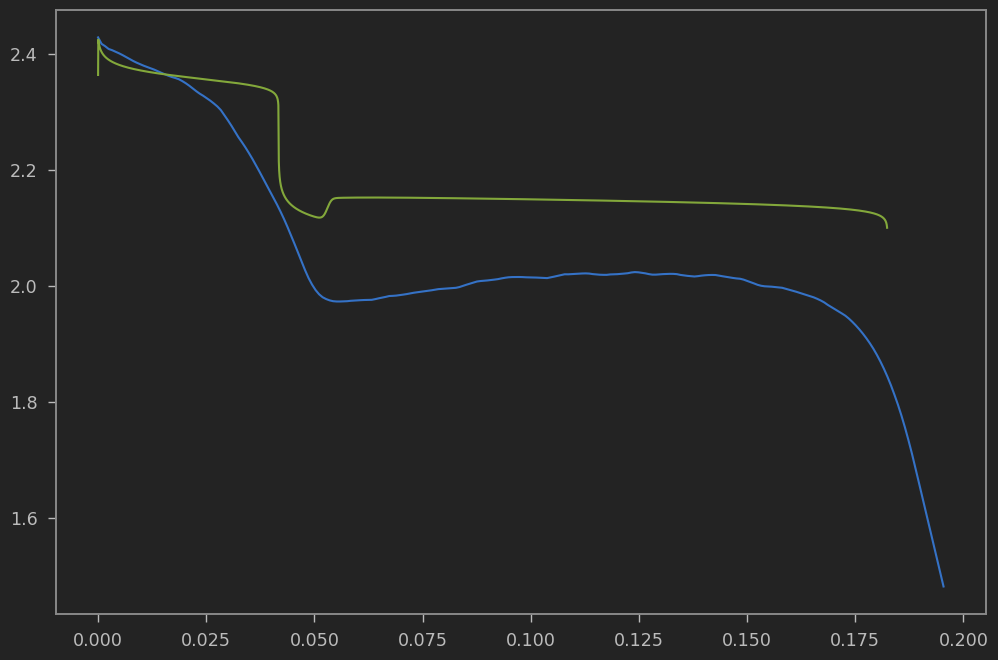

In [68]:
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
for sim in all_sims:
    plt.plot(sim['capacity'],sim['voltage'])
    
notify

In [150]:
# Here we will perform the charge fitting
def quick_norm(gradient):
    values = np.array(list(gradient.values()))
    return sum(values*values)

def gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage):
    fitted_params_dict, temp = inputs
    # create steps for each parameter to fit
    individually_stepped_params = []
    
    epsilon = 0.01
    for key_to_change in fitted_params_dict.keys():
        temp_dict = {}
        for key in fitted_params_dict.keys():
            if key == key_to_change:
                temp_dict[key] = fitted_params_dict[key]*(1+epsilon)
            else:
                temp_dict[key] = fitted_params_dict[key]
        individually_stepped_params.append(temp_dict)
    
    # run new simulations with individually stepped parameters
    individually_stepped_inputs = []
    for param_dict in individually_stepped_params:
        individually_stepped_inputs.append([param_dict, temp])
    
    print('Running Parallel Processes')
    individually_stepped_sims = Parallel(n_jobs=-1)(delayed(discharge_function)(inputs) for inputs in individually_stepped_inputs)
    
    # downsample each sim to be able to subtract from base_sim for numerical derivative
    voltage_cost_dict = {}
    mass_cost_dict = {}
    for i in range(0,len(individually_stepped_sims)):
        
        key = list(fitted_params_dict.keys())[i]
        sim = individually_stepped_sims[i]
        
        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sim['capacity'], sim['voltage'])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon
        voltage_cost = sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage)
        mass_error = sim['S8'][0]+sim['S4'][0]+sim['S2'][0]+sim['S1'][0]+sim['Sp'][0] - m_s_hunt
        mass_cost_dict[key] = mass_error
        voltage_cost_dict[key] = voltage_cost/len(temp_sim_V)
        
    total_voltage_cost = sum(abs(np.array(list(voltage_cost_dict.values()))))
    total_mass_cost = sum(abs(np.array(list(mass_cost_dict.values()))))
    gradient = {}
    for key in voltage_cost_dict.keys():
        gradient[key] = (voltage_cost_dict[key]/total_voltage_cost) + (mass_cost_dict[key]/total_mass_cost)
    
    # perform parameter update
    lam = 0.01
    #print('Gradient norm = ' + str(quick_norm(gradient)))
    updated_params_dict = {}
    for key in fitted_params_dict:
        updated_params_dict[key] = fitted_params_dict[key]*(1-lam*gradient[key]/quick_norm(gradient))
    print('The updated parameters are:')
    for item in updated_params_dict:
        print(item)
        print(updated_params_dict[item])
    print('The new mass is ' + str(sum(np.array(list(updated_params_dict.values())))))
    return updated_params_dict, gradient
    
    

def down_sampled_sim_voltage_func(Ah, V, exp_capacity, exp_voltage):

    # check if simulation stops short of experimental capacity and adjust
    #if Ah[-1] < exp_capacity[-1]:
    #    temp_exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]
    #else:
    #    temp_exp_capacity = exp_capacity
    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)
    
    return down_sampled_sim_voltage

def gradient_descent_proceedure(all_sims, all_params, temp):
    # get experimental data
    exp_capacity = discharge_data['30']['capacity']
    exp_voltage = discharge_data['30']['internal voltage'][0:len(exp_capacity)]
    
    # get new parameters
    params = all_params[-1]
    
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp = all_sims[-1].values()
    
    # get down-sampled sim voltage
    down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)
    
    condition = True
    while condition:
        inputs = all_params[-1], temp
        
        # perform gradient descent step from latest simulation & parameters
        print('\n\n Performing Gradient Descent Step \n\n')
        try:
            updated_params, gradient = gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage)

            # update parameter data
            all_params.append(updated_params)

            # perform simulation with new parameters
            inputs = all_params[-1], temp
            print('\n\n Performing New Simulation \n\n')
            new_base_sim = discharge_function(inputs)

            # down-sample sim data to experimental data
            t, Ah, V, S8, S4, S2, S1, Sp = new_base_sim.values()
            down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)

            # update simulation data set
            all_sims.append(new_base_sim)
        except:
            condition = False
        #if quick_norm(gradient)<1e-3:
        #    condition = False
        if len(all_sims) > 50:
            condition = False
            
    return all_sims, all_params

In [151]:
all_params = [
    {
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5]
    }                      
]
temp_c = 30
temp_k = temp_c + 272.15
all_sims = [base_discharge_sim_dict]
all_sims, all_params = gradient_descent_proceedure(all_sims, all_params, temp_k)



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.16635796694767302
Initial Condition for S4 ion [g]
0.0008006379393245873
Initial Condition for S2 ion [g]
2.70976195188077e-07
Initial Condition for S ion [g]
1.0208908986683527e-07
Initial Condition for Precipitated Sulfur [g]
1.688871041865608e-07
The new mass is 0.16715914683938685


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.16635796694767302, 'Initial Condition for S4 ion [g]': 0.0008006379393245873, 'Initial Condition for S2 ion [g]': 2.70976195188077e-07, 'Initial Condition for S ion [g]': 1.0208908986683527e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.688871041865608e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.16508830177968606
Initial Condition for S4 ion [g]
0.0008016552549679501
Initial Condition for S2 ion [g]
2.7131837651666713e-07
Initial Condition for S ion [g]
1.0221793911511846e-07
Initial Condition for Precipitated Sulfur [g]
1.6910465200616909e-07
The new mass is 0.16589049967562164


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.16508830177968606, 'Initial Condition for S4 ion [g]': 0.0008016552549679501, 'Initial Condition for S2 ion [g]': 2.7131837651666713e-07, 'Initial Condition for S ion [g]': 1.0221793911511846e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6910465200616909e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.16366539063530094
Initial Condition for S4 ion [g]
0.0008033648515604724
Initial Condition for S2 ion [g]
2.718861290974237e-07
Initial Condition for S ion [g]
1.0244305945733625e-07
Initial Condition for Precipitated Sulfur [g]
1.6947525870729465e-07
The new mass is 0.16446929929130868


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.16366539063530094, 'Initial Condition for S4 ion [g]': 0.0008033648515604724, 'Initial Condition for S2 ion [g]': 2.718861290974237e-07, 'Initial Condition for S ion [g]': 1.0244305945733625e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6947525870729465e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1621735999854588
Initial Condition for S4 ion [g]
0.0008051795733750457
Initial Condition for S2 ion [g]
2.7250863967894544e-07
Initial Condition for S ion [g]
1.0267755077083303e-07
Initial Condition for Precipitated Sulfur [g]
1.6986121967731572e-07
The new mass is 0.16297932460624398


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1621735999854588, 'Initial Condition for S4 ion [g]': 0.0008051795733750457, 'Initial Condition for S2 ion [g]': 2.7250863967894544e-07, 'Initial Condition for S ion [g]': 1.0267755077083303e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6986121967731572e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1606277682088226
Initial Condition for S4 ion [g]
0.0008069946215915011
Initial Condition for S2 ion [g]
2.7317570568832084e-07
Initial Condition for S ion [g]
1.0292707005284438e-07
Initial Condition for Precipitated Sulfur [g]
1.7027397039173419e-07
The new mass is 0.16143530920716026


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1606277682088226, 'Initial Condition for S4 ion [g]': 0.0008069946215915011, 'Initial Condition for S2 ion [g]': 2.7317570568832084e-07, 'Initial Condition for S ion [g]': 1.0292707005284438e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7027397039173419e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.15906279749551697
Initial Condition for S4 ion [g]
0.0008088434003768928
Initial Condition for S2 ion [g]
2.7385730608479304e-07
Initial Condition for S ion [g]
1.03182407994147e-07
Initial Condition for Precipitated Sulfur [g]
1.7069557431913303e-07
The new mass is 0.15987218863118227


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.15906279749551697, 'Initial Condition for S4 ion [g]': 0.0008088434003768928, 'Initial Condition for S2 ion [g]': 2.7385730608479304e-07, 'Initial Condition for S ion [g]': 1.03182407994147e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7069557431913303e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.15906279749551697, 'Initial Condition for S4 ion [g]': 0.0008088434003768928, 'Initial Condition for S2 ion [g]': 2.7385730608479304e-07, 'Initial Condition for S ion [g]': 1.03182407994147e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7069557431913303e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.15750764801400538
Initial Condition for S4 ion [g]
0.0008108319220783541
Initial Condition for S2 ion [g]
2.7452131603447494e-07
Initial Condition for S ion [g]
1.034388466043797e-07
Initial Condition for Precipitated Sulfur [g]
1.7110669918280296e-07
The new mass is 0.15831902900294553


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.15750764801400538, 'Initial Condition for S4 ion [g]': 0.0008108319220783541, 'Initial Condition for S2 ion [g]': 2.7452131603447494e-07, 'Initial Condition for S ion [g]': 1.034388466043797e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7110669918280296e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.15750764801400538, 'Initial Condition for S4 ion [g]': 0.0008108319220783541, 'Initial Condition for S2 ion [g]': 2.7452131603447494e-07, 'Initial Condition for S ion [g]': 1.034388466043797e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7110669918280296e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.15592900703649967
Initial Condition for S4 ion [g]
0.0008128103022711416
Initial Condition for S2 ion [g]
2.7523367349471366e-07
Initial Condition for S ion [g]
1.0369788755820544e-07
Initial Condition for Precipitated Sulfur [g]
1.7153164155181523e-07
The new mass is 0.15674236780197343


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.15592900703649967, 'Initial Condition for S4 ion [g]': 0.0008128103022711416, 'Initial Condition for S2 ion [g]': 2.7523367349471366e-07, 'Initial Condition for S ion [g]': 1.0369788755820544e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7153164155181523e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.15437848582011454
Initial Condition for S4 ion [g]
0.0008148041896913491
Initial Condition for S2 ion [g]
2.7593189966004255e-07
Initial Condition for S ion [g]
1.0395514250753151e-07
Initial Condition for Precipitated Sulfur [g]
1.7195584357135575e-07
The new mass is 0.1551938418526916


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.15437848582011454, 'Initial Condition for S4 ion [g]': 0.0008148041896913491, 'Initial Condition for S2 ion [g]': 2.7593189966004255e-07, 'Initial Condition for S ion [g]': 1.0395514250753151e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7195584357135575e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 3378.81 and h



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1528622966709164
Initial Condition for S4 ion [g]
0.0008167829389507604
Initial Condition for S2 ion [g]
2.7661376496920277e-07
Initial Condition for S ion [g]
1.0421186185157772e-07
Initial Condition for Precipitated Sulfur [g]
1.7237749531545458e-07
The new mass is 0.1536796328129893


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1528622966709164, 'Initial Condition for S4 ion [g]': 0.0008167829389507604, 'Initial Condition for S2 ion [g]': 2.7661376496920277e-07, 'Initial Condition for S ion [g]': 1.0421186185157772e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7237749531545458e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1528622966709164, 'Initial Condition for S4 ion [g]': 0.0008167829389507604, 'Initial Condition for S2 ion [g]': 2.7661376496920277e-07, 'Initial Condition for S ion [g]': 1.0421186185157772e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7237749531545458e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2474.76 and h



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.15134660399984004
Initial Condition for S4 ion [g]
0.0008187502205777305
Initial Condition for S2 ion [g]
2.7730815670560414e-07
Initial Condition for S ion [g]
1.0447320766307536e-07
Initial Condition for Precipitated Sulfur [g]
1.7280648729466276e-07
The new mass is 0.15216590880826944


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.15134660399984004, 'Initial Condition for S4 ion [g]': 0.0008187502205777305, 'Initial Condition for S2 ion [g]': 2.7730815670560414e-07, 'Initial Condition for S ion [g]': 1.0447320766307536e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7280648729466276e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.14985181898002084
Initial Condition for S4 ion [g]
0.000820978945104592
Initial Condition for S2 ion [g]
2.7802053388814335e-07
Initial Condition for S ion [g]
1.0474127906959001e-07
Initial Condition for Precipitated Sulfur [g]
1.732933382324743e-07
The new mass is 0.15067335398027665


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.14985181898002084, 'Initial Condition for S4 ion [g]': 0.000820978945104592, 'Initial Condition for S2 ion [g]': 2.7802053388814335e-07, 'Initial Condition for S ion [g]': 1.0474127906959001e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.732933382324743e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.14835807699884415
Initial Condition for S4 ion [g]
0.000822958139609607
Initial Condition for S2 ion [g]
2.7872299891693886e-07
Initial Condition for S ion [g]
1.0500568144859139e-07
Initial Condition for Precipitated Sulfur [g]
1.737276718995787e-07
The new mass is 0.149181592594806


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.14835807699884415, 'Initial Condition for S4 ion [g]': 0.000822958139609607, 'Initial Condition for S2 ion [g]': 2.7872299891693886e-07, 'Initial Condition for S ion [g]': 1.0500568144859139e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.737276718995787e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.14686923966754425
Initial Condition for S4 ion [g]
0.000825048001916901
Initial Condition for S2 ion [g]
2.7950668335623477e-07
Initial Condition for S ion [g]
1.0531187116468003e-07
Initial Condition for Precipitated Sulfur [g]
1.7418295976789855e-07
The new mass is 0.14769484667097546


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.14686923966754425, 'Initial Condition for S4 ion [g]': 0.000825048001916901, 'Initial Condition for S2 ion [g]': 2.7950668335623477e-07, 'Initial Condition for S ion [g]': 1.0531187116468003e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7418295976789855e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.14540137763672806
Initial Condition for S4 ion [g]
0.0008270769248482426
Initial Condition for S2 ion [g]
2.8021437215597696e-07
Initial Condition for S ion [g]
1.0557492385232251e-07
Initial Condition for Precipitated Sulfur [g]
1.746193618212749e-07
The new mass is 0.14622901497023413


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.14540137763672806, 'Initial Condition for S4 ion [g]': 0.0008270769248482426, 'Initial Condition for S2 ion [g]': 2.8021437215597696e-07, 'Initial Condition for S ion [g]': 1.0557492385232251e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.746193618212749e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.14395678353077274
Initial Condition for S4 ion [g]
0.0008291103301255025
Initial Condition for S2 ion [g]
2.8091477263215614e-07
Initial Condition for S ion [g]
1.058386101609721e-07
Initial Condition for Precipitated Sulfur [g]
1.7505233622612815e-07
The new mass is 0.14478645566661727


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.14395678353077274, 'Initial Condition for S4 ion [g]': 0.0008291103301255025, 'Initial Condition for S2 ion [g]': 2.8091477263215614e-07, 'Initial Condition for S ion [g]': 1.058386101609721e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7505233622612815e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.14251964031005065
Initial Condition for S4 ion [g]
0.0008311454367156542
Initial Condition for S2 ion [g]
2.8162289374359494e-07
Initial Condition for S ion [g]
1.0610494802384361e-07
Initial Condition for Precipitated Sulfur [g]
1.7548845625951075e-07
The new mass is 0.14335134896306434


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.14251964031005065, 'Initial Condition for S4 ion [g]': 0.0008311454367156542, 'Initial Condition for S2 ion [g]': 2.8162289374359494e-07, 'Initial Condition for S ion [g]': 1.0610494802384361e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7548845625951075e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1410706256212332
Initial Condition for S4 ion [g]
0.0008331193580052424
Initial Condition for S2 ion [g]
2.8237760268729243e-07
Initial Condition for S ion [g]
1.0638416421852118e-07
Initial Condition for Precipitated Sulfur [g]
1.7596691346648908e-07
The new mass is 0.1419043097079188


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1410706256212332, 'Initial Condition for S4 ion [g]': 0.0008331193580052424, 'Initial Condition for S2 ion [g]': 2.8237760268729243e-07, 'Initial Condition for S ion [g]': 1.0638416421852118e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7596691346648908e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.13964942232306352
Initial Condition for S4 ion [g]
0.0008352162515303309
Initial Condition for S2 ion [g]
2.830709626904265e-07
Initial Condition for S ion [g]
1.0665659747247988e-07
Initial Condition for Precipitated Sulfur [g]
1.7641408265252455e-07
The new mass is 0.14048520471623666


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.13964942232306352, 'Initial Condition for S4 ion [g]': 0.0008352162515303309, 'Initial Condition for S2 ion [g]': 2.830709626904265e-07, 'Initial Condition for S ion [g]': 1.0665659747247988e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7641408265252455e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.13818027814389772
Initial Condition for S4 ion [g]
0.0008370442869242807
Initial Condition for S2 ion [g]
2.8386936750387226e-07
Initial Condition for S ion [g]
1.0696868067575055e-07
Initial Condition for Precipitated Sulfur [g]
1.7690609463449105e-07
The new mass is 0.1390178901749648


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.13818027814389772, 'Initial Condition for S4 ion [g]': 0.0008370442869242807, 'Initial Condition for S2 ion [g]': 2.8386936750387226e-07, 'Initial Condition for S ion [g]': 1.0696868067575055e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7690609463449105e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.13818027814389772, 'Initial Condition for S4 ion [g]': 0.0008370442869242807, 'Initial Condition for S2 ion [g]': 2.8386936750387226e-07, 'Initial Condition for S ion [g]': 1.0696868067575055e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7690609463449105e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.13679474765253438
Initial Condition for S4 ion [g]
0.0008395287034369625
Initial Condition for S2 ion [g]
2.847184574179578e-07
Initial Condition for S ion [g]
1.072865170741374e-07
Initial Condition for Precipitated Sulfur [g]
1.7738084897727318e-07
The new mass is 0.13763484574179483


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.13679474765253438, 'Initial Condition for S4 ion [g]': 0.0008395287034369625, 'Initial Condition for S2 ion [g]': 2.847184574179578e-07, 'Initial Condition for S ion [g]': 1.072865170741374e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7738084897727318e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.13679474765253438, 'Initial Condition for S4 ion [g]': 0.0008395287034369625, 'Initial Condition for S2 ion [g]': 2.847184574179578e-07, 'Initial Condition for S ion [g]': 1.072865170741374e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7738084897727318e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.13542481858767225
Initial Condition for S4 ion [g]
0.0008419386643022522
Initial Condition for S2 ion [g]
2.8555514585974584e-07
Initial Condition for S ion [g]
1.0756945329969621e-07
Initial Condition for Precipitated Sulfur [g]
1.778447547580779e-07
The new mass is 0.1362673282213284


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.13542481858767225, 'Initial Condition for S4 ion [g]': 0.0008419386643022522, 'Initial Condition for S2 ion [g]': 2.8555514585974584e-07, 'Initial Condition for S ion [g]': 1.0756945329969621e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.778447547580779e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1340724870516887
Initial Condition for S4 ion [g]
0.0008441580347302734
Initial Condition for S2 ion [g]
2.8627755968160877e-07
Initial Condition for S ion [g]
1.078412259364203e-07
Initial Condition for Precipitated Sulfur [g]
1.782886790358427e-07
The new mass is 0.13491721749388366


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1340724870516887, 'Initial Condition for S4 ion [g]': 0.0008441580347302734, 'Initial Condition for S2 ion [g]': 2.8627755968160877e-07, 'Initial Condition for S ion [g]': 1.078412259364203e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.782886790358427e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1340724870516887, 'Initial Condition for S4 ion [g]': 0.0008441580347302734, 'Initial Condition for S2 ion [g]': 2.8627755968160877e-07, 'Initial Condition for S ion [g]': 1.078412259364203e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.782886790358427e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2451.46 and h



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1326572825963481
Initial Condition for S4 ion [g]
0.0008465528863066654
Initial Condition for S2 ion [g]
2.868891316990659e-07
Initial Condition for S ion [g]
1.081455406534335e-07
Initial Condition for Precipitated Sulfur [g]
1.7880201928953805e-07
The new mass is 0.13350440931934643


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1326572825963481, 'Initial Condition for S4 ion [g]': 0.0008465528863066654, 'Initial Condition for S2 ion [g]': 2.868891316990659e-07, 'Initial Condition for S ion [g]': 1.081455406534335e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.7880201928953805e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.13132901621611037
Initial Condition for S4 ion [g]
0.000849134950080772
Initial Condition for S2 ion [g]
2.878990755506183e-07
Initial Condition for S ion [g]
1.0845516444059782e-07
Initial Condition for Precipitated Sulfur [g]
1.794272616013124e-07
The new mass is 0.13217872694769273


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.13132901621611037, 'Initial Condition for S4 ion [g]': 0.000849134950080772, 'Initial Condition for S2 ion [g]': 2.878990755506183e-07, 'Initial Condition for S ion [g]': 1.0845516444059782e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.794272616013124e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.13000117044727852
Initial Condition for S4 ion [g]
0.0008512115879303763
Initial Condition for S2 ion [g]
2.886386360134966e-07
Initial Condition for S ion [g]
1.0873323812026428e-07
Initial Condition for Precipitated Sulfur [g]
1.798816560920262e-07
The new mass is 0.13085295928873913


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.13000117044727852, 'Initial Condition for S4 ion [g]': 0.0008512115879303763, 'Initial Condition for S2 ion [g]': 2.886386360134966e-07, 'Initial Condition for S ion [g]': 1.0873323812026428e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.798816560920262e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.12852876408361233
Initial Condition for S4 ion [g]
0.0008530942208778559
Initial Condition for S2 ion [g]
2.8951889485592274e-07
Initial Condition for S ion [g]
1.0906413947306861e-07
Initial Condition for Precipitated Sulfur [g]
1.8042516119679104e-07
The new mass is 0.1293824373126857


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12852876408361233, 'Initial Condition for S4 ion [g]': 0.0008530942208778559, 'Initial Condition for S2 ion [g]': 2.8951889485592274e-07, 'Initial Condition for S ion [g]': 1.0906413947306861e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8042516119679104e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed




 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.12719318620534317
Initial Condition for S4 ion [g]
0.0008553788577360254
Initial Condition for S2 ion [g]
2.9018633059351726e-07
Initial Condition for S ion [g]
1.0935998097091285e-07
Initial Condition for Precipitated Sulfur [g]
1.8091146904131925e-07
The new mass is 0.1280491455208598


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12719318620534317, 'Initial Condition for S4 ion [g]': 0.0008553788577360254, 'Initial Condition for S2 ion [g]': 2.9018633059351726e-07, 'Initial Condition for S ion [g]': 1.0935998097091285e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8091146904131925e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.12597446010717747
Initial Condition for S4 ion [g]
0.0008595077359245463
Initial Condition for S2 ion [g]
2.911235239246383e-07
Initial Condition for S ion [g]
1.0971233572951492e-07
Initial Condition for Precipitated Sulfur [g]
1.818143730413019e-07
The new mass is 0.1268345504933347


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12597446010717747, 'Initial Condition for S4 ion [g]': 0.0008595077359245463, 'Initial Condition for S2 ion [g]': 2.911235239246383e-07, 'Initial Condition for S ion [g]': 1.0971233572951492e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.818143730413019e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12597446010717747, 'Initial Condition for S4 ion [g]': 0.0008595077359245463, 'Initial Condition for S2 ion [g]': 2.911235239246383e-07, 'Initial Condition for S ion [g]': 1.0971233572951492e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.818143730413019e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.12471525596387523
Initial Condition for S4 ion [g]
0.000862560113198199
Initial Condition for S2 ion [g]
2.921759863715501e-07
Initial Condition for S ion [g]
1.1010847855133733e-07
Initial Condition for Precipitated Sulfur [g]
1.8242022694449543e-07
The new mass is 0.1255784007817653


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12471525596387523, 'Initial Condition for S4 ion [g]': 0.000862560113198199, 'Initial Condition for S2 ion [g]': 2.921759863715501e-07, 'Initial Condition for S ion [g]': 1.1010847855133733e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8242022694449543e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.12346671492468711
Initial Condition for S4 ion [g]
0.0008646998708897767
Initial Condition for S2 ion [g]
2.929113785559746e-07
Initial Condition for S ion [g]
1.1038516711635713e-07
Initial Condition for Precipitated Sulfur [g]
1.8287638800353086e-07
The new mass is 0.12433200096851056


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12346671492468711, 'Initial Condition for S4 ion [g]': 0.0008646998708897767, 'Initial Condition for S2 ion [g]': 2.929113785559746e-07, 'Initial Condition for S ion [g]': 1.1038516711635713e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8287638800353086e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.12216494576044787
Initial Condition for S4 ion [g]
0.0008665745332169248
Initial Condition for S2 ion [g]
2.9373059386531976e-07
Initial Condition for S ion [g]
1.1069362235495857e-07
Initial Condition for Precipitated Sulfur [g]
1.833855769584673e-07
The new mass is 0.12303210810345797


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12216494576044787, 'Initial Condition for S4 ion [g]': 0.0008665745332169248, 'Initial Condition for S2 ion [g]': 2.9373059386531976e-07, 'Initial Condition for S ion [g]': 1.1069362235495857e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.833855769584673e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12216494576044787, 'Initial Condition for S4 ion [g]': 0.0008665745332169248, 'Initial Condition for S2 ion [g]': 2.9373059386531976e-07, 'Initial Condition for S ion [g]': 1.1069362235495857e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.833855769584673e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.12087949809595944
Initial Condition for S4 ion [g]
0.0008688090602997825
Initial Condition for S2 ion [g]
2.9455451358949545e-07
Initial Condition for S ion [g]
1.1101899008394423e-07
Initial Condition for Precipitated Sulfur [g]
1.8383519856686455e-07
The new mass is 0.12174889656496145


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12087949809595944, 'Initial Condition for S4 ion [g]': 0.0008688090602997825, 'Initial Condition for S2 ion [g]': 2.9455451358949545e-07, 'Initial Condition for S ion [g]': 1.1101899008394423e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8383519856686455e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.12087949809595944, 'Initial Condition for S4 ion [g]': 0.0008688090602997825, 'Initial Condition for S2 ion [g]': 2.9455451358949545e-07, 'Initial Condition for S ion [g]': 1.1101899008394423e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8383519856686455e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11937067722975307
Initial Condition for S4 ion [g]
0.0008713381810245209
Initial Condition for S2 ion [g]
2.9557864816244834e-07
Initial Condition for S ion [g]
1.1131156226705229e-07
Initial Condition for Precipitated Sulfur [g]
1.8447104345804162e-07
The new mass is 0.12024260677203148


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11937067722975307, 'Initial Condition for S4 ion [g]': 0.0008713381810245209, 'Initial Condition for S2 ion [g]': 2.9557864816244834e-07, 'Initial Condition for S ion [g]': 1.1131156226705229e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8447104345804162e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11768900658835363
Initial Condition for S4 ion [g]
0.0008733739837451711
Initial Condition for S2 ion [g]
2.9649570373329603e-07
Initial Condition for S ion [g]
1.1179337140328214e-07
Initial Condition for Precipitated Sulfur [g]
1.8526802172859719e-07
The new mass is 0.11856297412919567


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11768900658835363, 'Initial Condition for S4 ion [g]': 0.0008733739837451711, 'Initial Condition for S2 ion [g]': 2.9649570373329603e-07, 'Initial Condition for S ion [g]': 1.1179337140328214e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8526802172859719e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11648991854334123
Initial Condition for S4 ion [g]
0.0008756197897236594
Initial Condition for S2 ion [g]
2.973942929226706e-07
Initial Condition for S ion [g]
1.120978762427999e-07
Initial Condition for Precipitated Sulfur [g]
1.8582752867762736e-07
The new mass is 0.11736613365276274


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11648991854334123, 'Initial Condition for S4 ion [g]': 0.0008756197897236594, 'Initial Condition for S2 ion [g]': 2.973942929226706e-07, 'Initial Condition for S ion [g]': 1.120978762427999e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8582752867762736e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1152753522471481
Initial Condition for S4 ion [g]
0.0008775877674005246
Initial Condition for S2 ion [g]
2.982065804452077e-07
Initial Condition for S ion [g]
1.1240334375137624e-07
Initial Condition for Precipitated Sulfur [g]
1.8633344093762197e-07
The new mass is 0.11615353695791378


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1152753522471481, 'Initial Condition for S4 ion [g]': 0.0008775877674005246, 'Initial Condition for S2 ion [g]': 2.982065804452077e-07, 'Initial Condition for S ion [g]': 1.1240334375137624e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8633344093762197e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11413436017662743
Initial Condition for S4 ion [g]
0.0008810344705552764
Initial Condition for S2 ion [g]
2.992877094120056e-07
Initial Condition for S ion [g]
1.1289127225407825e-07
Initial Condition for Precipitated Sulfur [g]
1.869121487051292e-07
The new mass is 0.11501599373831307


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11413436017662743, 'Initial Condition for S4 ion [g]': 0.0008810344705552764, 'Initial Condition for S2 ion [g]': 2.992877094120056e-07, 'Initial Condition for S ion [g]': 1.1289127225407825e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.869121487051292e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11501976032143975
Initial Condition for S4 ion [g]
0.0008820363028331526
Initial Condition for S2 ion [g]
2.996872554529319e-07
Initial Condition for S ion [g]
1.130412990452081e-07
Initial Condition for Precipitated Sulfur [g]
1.8716091968505363e-07
The new mass is 0.11590239651374708


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11501976032143975, 'Initial Condition for S4 ion [g]': 0.0008820363028331526, 'Initial Condition for S2 ion [g]': 2.996872554529319e-07, 'Initial Condition for S ion [g]': 1.130412990452081e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8716091968505363e-07}


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup f



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11385263749101823
Initial Condition for S4 ion [g]
0.0008842416321915759
Initial Condition for S2 ion [g]
3.004367779255329e-07
Initial Condition for S ion [g]
1.1333213668685662e-07
Initial Condition for Precipitated Sulfur [g]
1.8764248856186952e-07
The new mass is 0.11473748053461298


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11385263749101823, 'Initial Condition for S4 ion [g]': 0.0008842416321915759, 'Initial Condition for S2 ion [g]': 3.004367779255329e-07, 'Initial Condition for S ion [g]': 1.1333213668685662e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8764248856186952e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11187616616718829
Initial Condition for S4 ion [g]
0.0008875953492304654
Initial Condition for S2 ion [g]
3.0280926391849407e-07
Initial Condition for S ion [g]
1.1365301070607982e-07
Initial Condition for Precipitated Sulfur [g]
1.881752218212586e-07
The new mass is 0.1127643661539152


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11187616616718829, 'Initial Condition for S4 ion [g]': 0.0008875953492304654, 'Initial Condition for S2 ion [g]': 3.0280926391849407e-07, 'Initial Condition for S ion [g]': 1.1365301070607982e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.881752218212586e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1107043271261706
Initial Condition for S4 ion [g]
0.0008897640937820662
Initial Condition for S2 ion [g]
3.0364106180743084e-07
Initial Condition for S ion [g]
1.1394833984339508e-07
Initial Condition for Precipitated Sulfur [g]
1.886805821740411e-07
The new mass is 0.1115946974899365


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1107043271261706, 'Initial Condition for S4 ion [g]': 0.0008897640937820662, 'Initial Condition for S2 ion [g]': 3.0364106180743084e-07, 'Initial Condition for S ion [g]': 1.1394833984339508e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.886805821740411e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11154477048148156
Initial Condition for S4 ion [g]
0.0008908781288845657
Initial Condition for S2 ion [g]
3.0402819968147626e-07
Initial Condition for S ion [g]
1.1409201245733742e-07
Initial Condition for Precipitated Sulfur [g]
1.8892242425716943e-07
The new mass is 0.11243625565300254


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11154477048148156, 'Initial Condition for S4 ion [g]': 0.0008908781288845657, 'Initial Condition for S2 ion [g]': 3.0402819968147626e-07, 'Initial Condition for S ion [g]': 1.1409201245733742e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8892242425716943e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11041831853929691
Initial Condition for S4 ion [g]
0.0008930527259390027
Initial Condition for S2 ion [g]
3.0480719755040337e-07
Initial Condition for S ion [g]
1.1438427710015611e-07
Initial Condition for Precipitated Sulfur [g]
1.8941365327193439e-07
The new mass is 0.11131197987036386


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11041831853929691, 'Initial Condition for S4 ion [g]': 0.0008930527259390027, 'Initial Condition for S2 ion [g]': 3.0480719755040337e-07, 'Initial Condition for S ion [g]': 1.1438427710015611e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.8941365327193439e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.1113373962019996
Initial Condition for S4 ion [g]
0.0008944802372768286
Initial Condition for S2 ion [g]
3.0527549322252366e-07
Initial Condition for S ion [g]
1.1451452023659473e-07
Initial Condition for Precipitated Sulfur [g]
1.896295637503301e-07
The new mass is 0.11223248585885363


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1113373962019996, 'Initial Condition for S4 ion [g]': 0.0008944802372768286, 'Initial Condition for S2 ion [g]': 3.0527549322252366e-07, 'Initial Condition for S ion [g]': 1.1451452023659473e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.896295637503301e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.1113373962019996, 'Initial Condition for S4 ion [g]': 0.0008944802372768286, 'Initial Condition for S2 ion [g]': 3.0527549322252366e-07, 'Initial Condition for S ion [g]': 1.1451452023659473e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.896295637503301e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11016313683636036
Initial Condition for S4 ion [g]
0.0008965049974327624
Initial Condition for S2 ion [g]
3.061500718479529e-07
Initial Condition for S ion [g]
1.1484198265905702e-07
Initial Condition for Precipitated Sulfur [g]
1.9023222851740313e-07
The new mass is 0.11106025305807615


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11016313683636036, 'Initial Condition for S4 ion [g]': 0.0008965049974327624, 'Initial Condition for S2 ion [g]': 3.061500718479529e-07, 'Initial Condition for S ion [g]': 1.1484198265905702e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.9023222851740313e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.11104305528343533
Initial Condition for S4 ion [g]
0.0008973722849901885
Initial Condition for S2 ion [g]
3.065815221439922e-07
Initial Condition for S ion [g]
1.1500395899379137e-07
Initial Condition for Precipitated Sulfur [g]
1.9050152171443571e-07
The new mass is 0.11194103965542837


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.11104305528343533, 'Initial Condition for S4 ion [g]': 0.0008973722849901885, 'Initial Condition for S2 ion [g]': 3.065815221439922e-07, 'Initial Condition for S ion [g]': 1.1500395899379137e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.9050152171443571e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.10988380316860628
Initial Condition for S4 ion [g]
0.000899717275334303
Initial Condition for S2 ion [g]
3.073490771292059e-07
Initial Condition for S ion [g]
1.153352104888792e-07
Initial Condition for Precipitated Sulfur [g]
1.9107003093743503e-07
The new mass is 0.11078413419825915


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.10988380316860628, 'Initial Condition for S4 ion [g]': 0.000899717275334303, 'Initial Condition for S2 ion [g]': 3.073490771292059e-07, 'Initial Condition for S ion [g]': 1.153352104888792e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.9107003093743503e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp

trying number of time steps 10000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.10988380316860628, 'Initial Condition for S4 ion [g]': 0.000899717275334303, 'Initial Condition for S2 ion [g]': 3.073490771292059e-07, 'Initial Condition for S ion [g]': 1.153352104888792e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.9107003093743503e-07}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.10851077058030853
Initial Condition for S4 ion [g]
0.0009024522189868594
Initial Condition for S2 ion [g]
3.078208349706826e-07
Initial Condition for S ion [g]
1.1580222101366701e-07
Initial Condition for Precipitated Sulfur [g]
1.918813488242477e-07
The new mass is 0.10941383830370019


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.10851077058030853, 'Initial Condition for S4 ion [g]': 0.0009024522189868594, 'Initial Condition for S2 ion [g]': 3.078208349706826e-07, 'Initial Condition for S ion [g]': 1.1580222101366701e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.918813488242477e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp



 Performing Gradient Descent Step 


Running Parallel Processes
The updated parameters are:
Initial Condition for S8 ion [g]
0.10718450966497375
Initial Condition for S4 ion [g]
0.0009045888713249796
Initial Condition for S2 ion [g]
3.089836164400951e-07
Initial Condition for S ion [g]
1.1623843886627028e-07
Initial Condition for Precipitated Sulfur [g]
1.9232467135350732e-07
The new mass is 0.1080897160830254


 Performing New Simulation 


Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.10718450966497375, 'Initial Condition for S4 ion [g]': 0.0009045888713249796, 'Initial Condition for S2 ion [g]': 3.089836164400951e-07, 'Initial Condition for S ion [g]': 1.1623843886627028e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.9232467135350732e-07}


The linesearch algorithm failed with too small a step.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cp

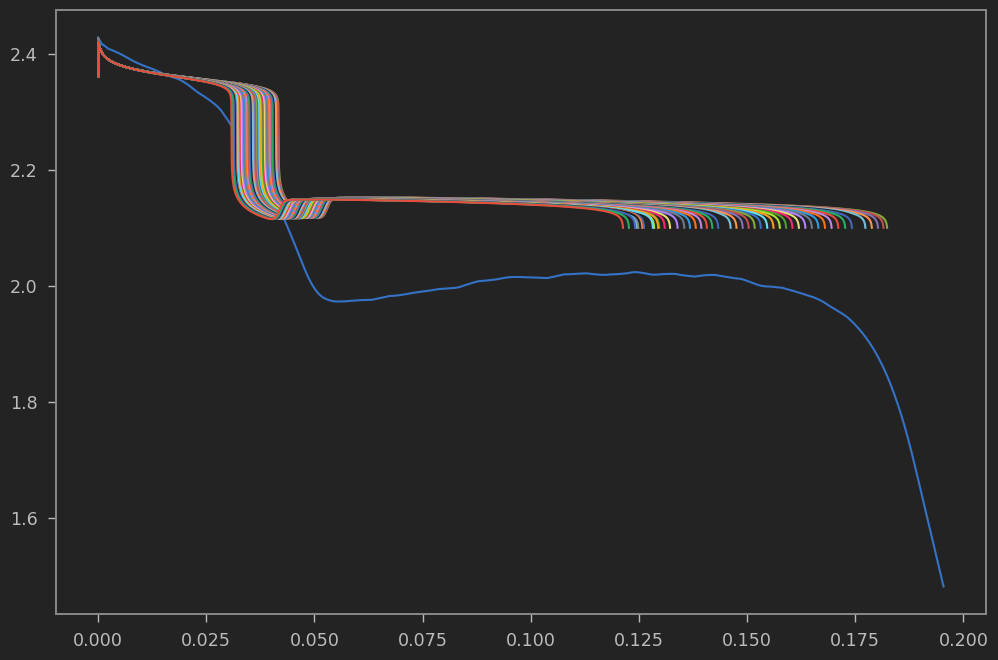

In [152]:
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
for sim in all_sims:
    plt.plot(sim['capacity'],sim['voltage'])
    
notify

In [153]:
for sim in all_sims:
    print(sim['capacity'][-1])

0.18234263232806394
0.18150360999758378
0.18023672718796283
0.17881623982644887
0.1773256829417877
0.17577967831924235
0.17421299744397514
0.17265473324178882
0.17107133409867434
0.1695146024626881
0.16799079444808881
0.16646587651461792
0.16496120114005136
0.1634553411782126
0.1619534301009785
0.16047089248073787
0.15901051055399404
0.15755608313885233
0.15608823062154284
0.15464706194728592
0.1531553797562843
0.1517478898045292
0.150354877572284
0.1489781696925253
0.14753570607762986
0.14618128169641809
0.1448251160061133
0.14331934806150903
0.1419522014387401
0.14070556352509309
0.139415206807963
0.13813355354326565
0.13679555864524698
0.13547323753855292
0.13391929219242857
0.1321842240162289
0.13094633917527243
0.1296904159693514
0.12851138833494724
0.1294297320355387
0.12822205743518258
0.1261735994361633
0.12495745272227277
0.12583204569881196
0.12466276033462463
0.12561949033720113
0.12440004077628128
0.12531601629952083
0.12411229456569058
0.12268477833365685
0.121303678987888

In [127]:
blah

{'Initial Condition for S8 ion [g]': 0.019185081777251655,
 'Initial Condition for S4 ion [g]': 0.019185081777251655,
 'Initial Condition for S2 ion [g]': 0.019185081777251655,
 'Initial Condition for S ion [g]': 1.0,
 'Initial Condition for Precipitated Sulfur [g]': 0.019185081777251655}